In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix
from pandas.plotting import parallel_coordinates
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_columns = None

# 1 Data for Feature Engineering
First we ingested the Market Check Used Car Inventory data file containing used cars accross United States (~6.7 million instances with 38 features
Then we did initial data wraggling in SQLite and Alteryx (Removed columns with null values, single values, huge descriptive text values. Also instances with null values and 4 digit zipcodes

In [3]:
# Read in CSV file
car_data_clean = pd.read_csv(r'C:\Users\yexin\Desktop\KBB\car_data_clean_final.csv')

In [4]:
# Check in the initial data set
print(car_data_clean.shape)

(1704427, 52)


In [6]:
feature_df= car_data_clean.drop (car_data_clean.columns[0], axis =1)
feature_df.shape

(1704427, 51)

In [7]:
#remove obvious duplicate columns
c=['year_is','dom_180_is','state_ss','County', 'State short','State full','YEAR']
#c=['YEAR']
feature_df.drop(c, inplace=True, axis=1)

In [8]:
df_vol = feature_df['make_ss'].value_counts()
df_vol_10 = df_vol.head(10).to_frame(name='makes')
#print(df_vol_10.index)
df_top10 = feature_df.loc[feature_df['make_ss'].isin(df_vol_10.index)]
#print(df_top10.head())

In [9]:
feature_df=df_top10
feature_df.shape 

(1175553, 44)

# Data Visualization
Performed exploratory data analysis to better understand how data is distributed

#### EDA1: See how Car's listed price  distributed.
With this information above we can see that the prices are skewed right. Most of the price are around 200,000 and some outliers lies above 300,000. We will eventually want to get rid of the them to get a normal distribution of the independent variable (`Price Fs`) for machine learning.

In [10]:
feature_df.columns

Index(['id', 'vin_ss', 'price_fs', 'miles_fs', 'stock_no_ss', 'make_ss',
       'model_ss', 'trim_ss', 'vehicle_type_ss', 'body_type_ss',
       'drivetrain_ss', 'engine_ss', 'engine_size_ss', 'transmission_ss',
       'doors_is', 'cylinders_is', 'interior_color_ss', 'exterior_color_ss',
       'zip_is', 'dom_is', 'msrp_fs', 'dom_active_is', 'is_certified_is',
       'fuel_type_ss', 'scraped_at_dts', 'status_date_dts', 'city_ss', 'AGE',
       'type', 'decommissioned', 'primary_city', 'state', 'county', 'timezone',
       'latitude', 'longitude', 'irs_estimated_population_2015', 'Rank',
       'Per Capita income', 'Median Household income', 'Median Family income',
       'Population', 'Number of households', 'Regions'],
      dtype='object')

In [11]:
feature_df ['price_fs'].describe()

count   1175553.000
mean      21240.487
std       10615.012
min        1195.000
25%       14136.000
50%       18995.000
75%       26999.000
max      999917.000
Name: price_fs, dtype: float64

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


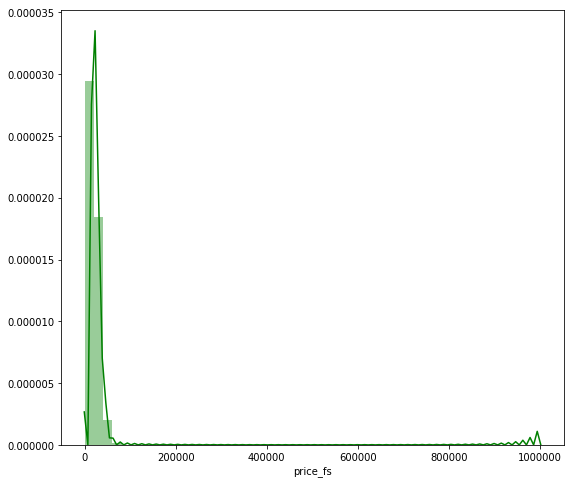

In [12]:
plt.figure(figsize=(9, 8))
sns.distplot(feature_df['price_fs'], color='g', bins=50)

In [13]:
#obviously, we have outerlier of car price. So we need to remove outliers

In [14]:
ol = (feature_df['price_fs'] > 5000) & (feature_df['price_fs'] < 50000) 

In [15]:
feature_df1 = feature_df[ol]

In [16]:
# outterlier is removed
feature_df1.shape

(1141865, 44)

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


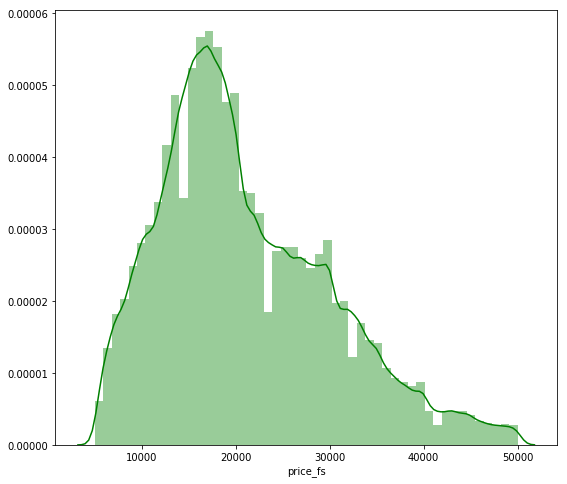

In [17]:
# so  now the car price distribution looks more even
plt.figure(figsize=(9, 8))
sns.distplot(feature_df1['price_fs'], color='g', bins=50)

#### EDA2: Numerical Data Distribution
Features such as 'Miles Fs' seems to share a similar distributon to the one we have with 'Price Fs'.  Let see if we can find new clue later.

In [17]:
# realized that some of the similar information can impacted the coorelation caculation.  so we need remove the similar features
feature_df2 = feature_df1

In [18]:
feature_df2.columns

Index(['id', 'vin_ss', 'price_fs', 'miles_fs', 'stock_no_ss', 'make_ss',
       'model_ss', 'trim_ss', 'vehicle_type_ss', 'body_type_ss',
       'drivetrain_ss', 'engine_ss', 'engine_size_ss', 'transmission_ss',
       'doors_is', 'cylinders_is', 'interior_color_ss', 'exterior_color_ss',
       'zip_is', 'dom_is', 'msrp_fs', 'dom_active_is', 'is_certified_is',
       'fuel_type_ss', 'scraped_at_dts', 'status_date_dts', 'city_ss', 'AGE',
       'type', 'decommissioned', 'primary_city', 'state', 'county', 'timezone',
       'latitude', 'longitude', 'irs_estimated_population_2015', 'Rank',
       'Per Capita income', 'Median Household income', 'Median Family income',
       'Population', 'Number of households', 'Regions'],
      dtype='object')

In [19]:
list(set(feature_df2.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [20]:
df_num = feature_df2.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,price_fs,miles_fs,engine_size_ss,doors_is,cylinders_is,zip_is,dom_is,msrp_fs,dom_active_is,is_certified_is,AGE,decommissioned,latitude,longitude,irs_estimated_population_2015,Rank,Population,Number of households
3,41250,23145,3.600,4,6,37067,52,41250,26,0,3.000,0.000,35.920,-86.840,26640.000,40.000,188935.000,66364.000
5,5999,129614,5.700,4,8,61244,41,5999,40,0,14.000,0.000,41.520,-90.390,20630.000,751.000,147477.000,60456.000
6,8979,58858,1.600,4,4,92655,143,8979,26,0,5.000,0.000,33.750,-117.980,8020.000,144.000,3051771.000,995512.000
7,16477,13705,1.400,4,4,48150,88,16477,44,0,3.000,0.000,42.370,-83.380,25930.000,1735.000,1804507.000,670987.000
8,27500,55574,5.300,4,8,43125,72,27500,15,1,4.000,0.000,39.860,-82.890,12020.000,461.000,1181824.000,468295.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F52518E7B8>,
      dtype=object)

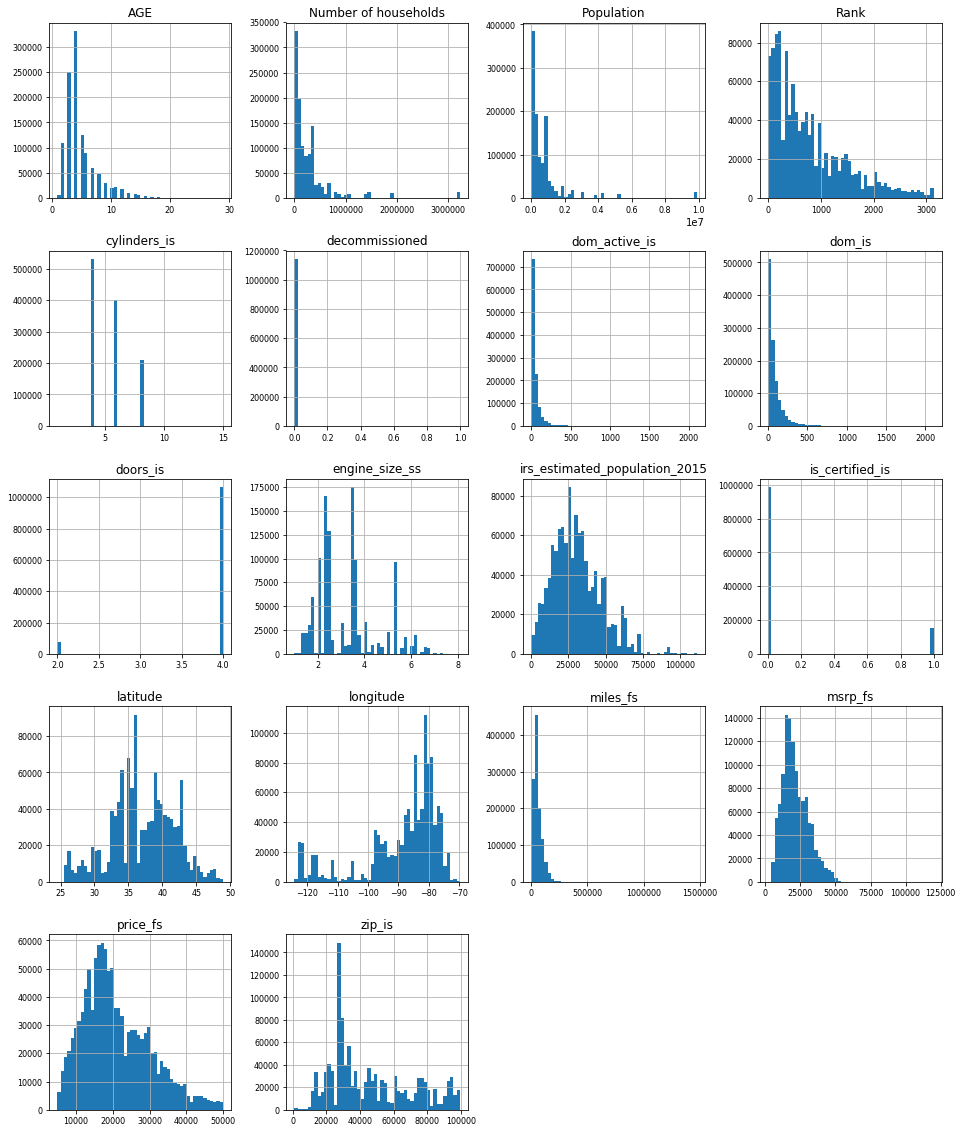

In [21]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

#### EDA3: Age of Car Distribution and Analysis

In [22]:
feature_df3=feature_df2

In [23]:
# Adding new features...Create Category for New Car and Old Cars
feature_df3['is_newer'] = np.where(feature_df3['AGE']<10,1,0)

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
df_num2 = feature_df3.select_dtypes(include = ['float64', 'int64','int32'])
df_num2.head(5)

,price_fs,miles_fs,engine_size_ss,doors_is,cylinders_is,zip_is,dom_is,msrp_fs,dom_active_is,is_certified_is,AGE,decommissioned,latitude,longitude,irs_estimated_population_2015,Rank,Population,Number of households,is_newer
3,41250,23145,3.600,4,6,37067,52,41250,26,0,3.000,0.000,35.920,-86.840,26640.000,40.000,188935.000,66364.000,1
5,5999,129614,5.700,4,8,61244,41,5999,40,0,14.000,0.000,41.520,-90.390,20630.000,751.000,147477.000,60456.000,0
6,8979,58858,1.600,4,4,92655,143,8979,26,0,5.000,0.000,33.750,-117.980,8020.000,144.000,3051771.000,995512.000,1
7,16477,13705,1.400,4,4,48150,88,16477,44,0,3.000,0.000,42.370,-83.380,25930.000,1735.000,1804507.000,670987.000,1
8,27500,55574,5.300,4,8,43125,72,27500,15,1,4.000,0.000,39.860,-82.890,12020.000,461.000,1181824.000,468295.000,1


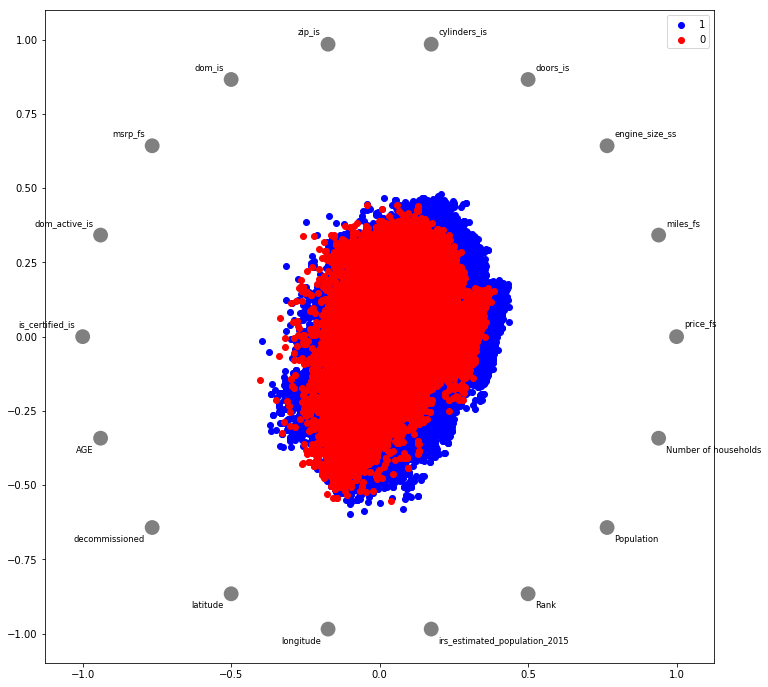

In [26]:
from pandas.plotting import radviz
plt.figure(figsize=(8,8))
radviz(df_num2, 'is_newer',color=['blue','red'])
plt.show()

In [147]:
# from pandas.plotting import parallel_coordinates

In [ ]:
#plt.figure(figsize=(20,5))
#dataset = feature_df3[['Number of households','zip_is', 'is_newer']]
#parallel_coordinates(dataset, 'is_newer')
#plt.show()                  

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


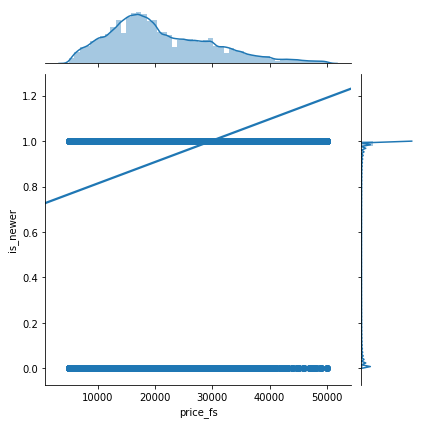

In [104]:
# this result is telling me: for the older cars (age>=10) are pure noise to the prediction, 
#since there is no corelation to car listing price
sns.jointplot(data=df_num2,x='price_fs',y='is_newer',kind='reg')

In [110]:
# so lets split the dat set to be newer car and older car
#newercar = df_num2[df_num2['is_newer']==1]
#oldercar = df_num2[df_num2['is_newer']==0]

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


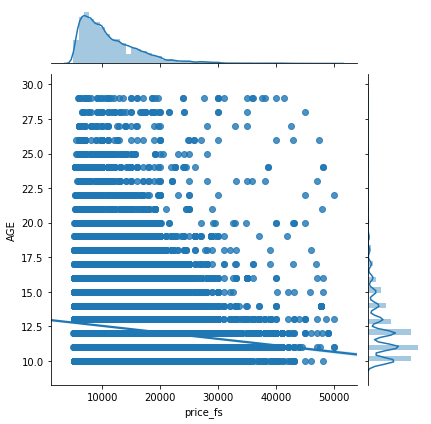

In [113]:
oldercar = df_num2[df_num2['is_newer']==0]
sns.jointplot(data=oldercar,x='price_fs',y='AGE',kind='reg')

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


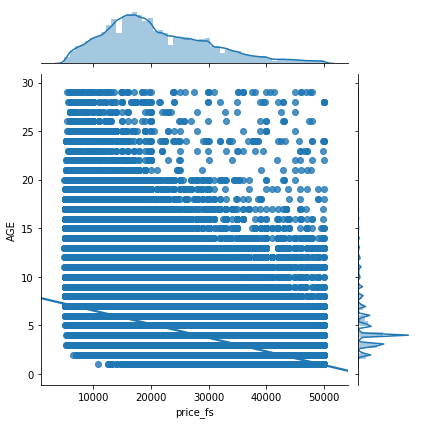

In [38]:
sns.jointplot(data=df_num,x='price_fs',y='AGE',kind='reg')

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


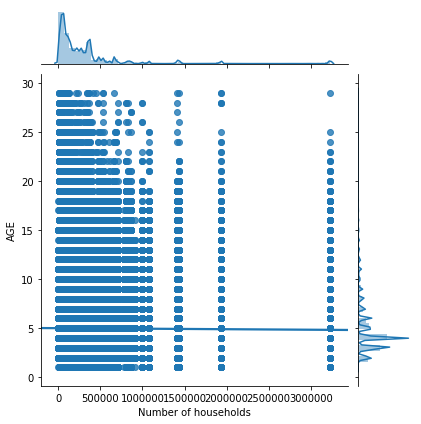

In [29]:
# Who perfer to buy the newer car
#sns.jointplot(data=df_num2,x= 'Number of households',y='AGE',kind='reg')

#### EDA4: HouseHold Distribution and Analysis

In [25]:
feature_df4=feature_df2

In [26]:
feature_df4.describe()

,price_fs,miles_fs,engine_size_ss,doors_is,cylinders_is,zip_is,dom_is,msrp_fs,dom_active_is,is_certified_is,AGE,decommissioned,latitude,longitude,irs_estimated_population_2015,Rank,Population,Number of households,is_newer
count,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000
mean,21058.313,56414.434,3.238,3.869,5.437,46434.226,89.323,21479.245,51.243,0.135,4.984,0.000,37.067,-88.621,30666.676,777.077,776704.741,280768.546,0.918
std,9154.466,38801.198,1.277,0.495,1.522,24392.824,130.787,9285.586,84.932,0.342,2.872,0.004,4.692,12.744,16242.179,689.554,1283122.648,433338.453,0.274
min,5001.000,0.000,1.000,2.000,1.000,1001.000,1.000,2000.000,0.000,0.000,1.000,0.000,24.550,-124.240,0.000,1.000,1387.000,549.000,0.000
25%,14488.000,29733.000,2.400,4.000,4.000,28110.000,23.000,14880.000,13.000,0.000,3.000,0.000,34.000,-94.140,18630.000,205.000,151408.000,57262.000,1.000
50%,18995.000,44964.000,3.000,4.000,6.000,37601.000,51.000,19555.000,29.000,0.000,4.000,0.000,36.860,-84.200,28930.000,559.000,380532.000,143717.000,1.000
75%,26990.000,75005.000,3.600,4.000,6.000,65202.000,108.000,27495.000,59.000,0.000,6.000,0.000,40.530,-80.070,41040.000,1121.000,929214.000,348627.000,1.000
max,49999.000,1472020.000,8.100,4.000,15.000,99362.000,2106.000,120000.000,2106.000,1.000,29.000,1.000,48.950,-69.710,111430.000,3139.000,9893481.000,3230383.000,1.000


C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


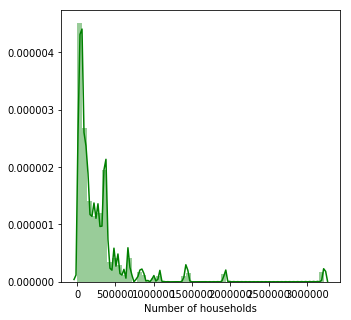

In [50]:
plt.figure(figsize=(5, 5))
sns.distplot(feature_df4['Number of households'], color='g', bins=50)

In [29]:
df_num4 = feature_df4.select_dtypes(include = ['float64', 'int64','int32'])

In [30]:
# different level of household income has different perference to car makes

In [31]:
lowincome = feature_df4[feature_df4['Number of households']<400000]

In [32]:
middleincome = feature_df4[(feature_df4['Number of households']>=400000)|(feature_df4['Number of households']<1000000)]

In [33]:
highincome =feature_df4[feature_df4['Number of households']>=1000000]

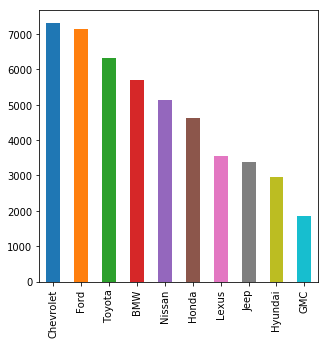

In [34]:
highincome['make_ss'].value_counts().plot(kind='bar', figsize=(5,5))

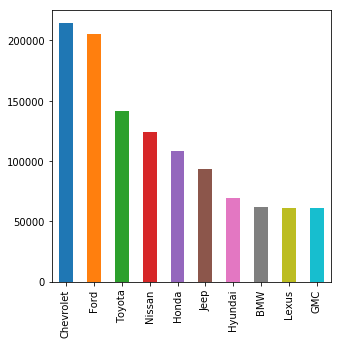

In [35]:
middleincome['make_ss'].value_counts().plot(kind='bar', figsize=(5,5))

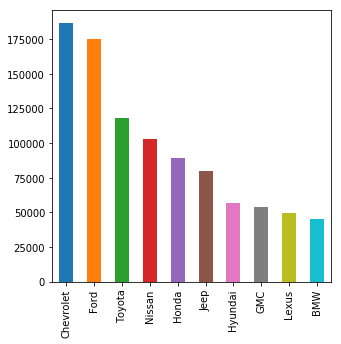

In [36]:
lowincome['make_ss'].value_counts().plot(kind='bar', figsize=(5,5))

#### EDA5: Population Data Distribution and Analysis

In [38]:
df_num4.columns

Index(['price_fs', 'miles_fs', 'engine_size_ss', 'doors_is', 'cylinders_is',
       'zip_is', 'dom_is', 'msrp_fs', 'dom_active_is', 'is_certified_is',
       'AGE', 'decommissioned', 'latitude', 'longitude',
       'irs_estimated_population_2015', 'Rank', 'Population',
       'Number of households', 'is_newer'],
      dtype='object')

C:\Users\yexin\Anaconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


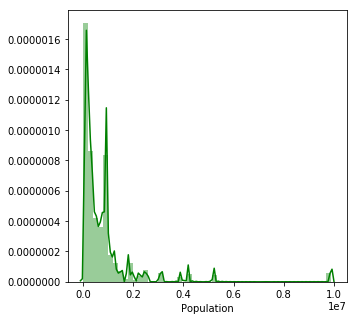

In [49]:
plt.figure(figsize=(5, 5))
sns.distplot(feature_df4['Population'], color='g', bins=50)

In [41]:
df_num4.describe()

,price_fs,miles_fs,engine_size_ss,doors_is,cylinders_is,zip_is,dom_is,msrp_fs,dom_active_is,is_certified_is,AGE,decommissioned,latitude,longitude,irs_estimated_population_2015,Rank,Population,Number of households,is_newer
count,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000,1141865.000
mean,21058.313,56414.434,3.238,3.869,5.437,46434.226,89.323,21479.245,51.243,0.135,4.984,0.000,37.067,-88.621,30666.676,777.077,776704.741,280768.546,0.918
std,9154.466,38801.198,1.277,0.495,1.522,24392.824,130.787,9285.586,84.932,0.342,2.872,0.004,4.692,12.744,16242.179,689.554,1283122.648,433338.453,0.274
min,5001.000,0.000,1.000,2.000,1.000,1001.000,1.000,2000.000,0.000,0.000,1.000,0.000,24.550,-124.240,0.000,1.000,1387.000,549.000,0.000
25%,14488.000,29733.000,2.400,4.000,4.000,28110.000,23.000,14880.000,13.000,0.000,3.000,0.000,34.000,-94.140,18630.000,205.000,151408.000,57262.000,1.000
50%,18995.000,44964.000,3.000,4.000,6.000,37601.000,51.000,19555.000,29.000,0.000,4.000,0.000,36.860,-84.200,28930.000,559.000,380532.000,143717.000,1.000
75%,26990.000,75005.000,3.600,4.000,6.000,65202.000,108.000,27495.000,59.000,0.000,6.000,0.000,40.530,-80.070,41040.000,1121.000,929214.000,348627.000,1.000
max,49999.000,1472020.000,8.100,4.000,15.000,99362.000,2106.000,120000.000,2106.000,1.000,29.000,1.000,48.950,-69.710,111430.000,3139.000,9893481.000,3230383.000,1.000


In [45]:
largepopulation = feature_df4[feature_df4['Population']>=1283122]

In [46]:
smallpolulation = feature_df4[feature_df4['Population']<1283122]

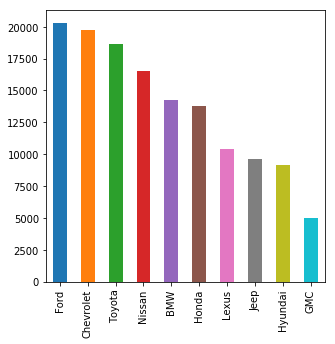

In [47]:
largepopulation['make_ss'].value_counts().plot(kind='bar', figsize=(5,5))

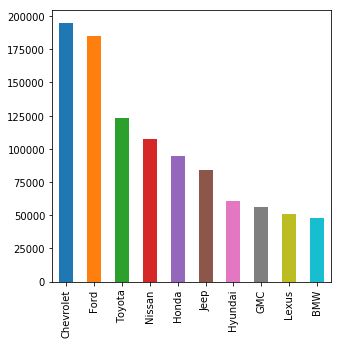

In [48]:
smallpolulation['make_ss'].value_counts().plot(kind='bar', figsize=(5,5))

#### EDA5: Feature Correlation

In [44]:
df_num_corr = df_num3.corr()['price_fs'] 
golden_features_list = df_num_corr[abs(df_num_corr) > 0.3].sort_values(ascending=False)
print("There is {} strongly correlated values with Car Price:\n{}".format(len(golden_features_list), golden_features_list))

There is 7 strongly correlated values with Car Price:
price_fs          1.000
msrp_fs           0.991
cylinders_is      0.514
engine_size_ss    0.502
is_newer          0.315
AGE              -0.441
miles_fs         -0.442
Name: price_fs, dtype: float64


In [45]:
df_num3.columns

Index(['price_fs', 'miles_fs', 'engine_size_ss', 'doors_is', 'cylinders_is',
       'zip_is', 'dom_is', 'msrp_fs', 'dom_active_is', 'is_certified_is',
       'AGE', 'decommissioned', 'latitude', 'longitude',
       'irs_estimated_population_2015', 'Rank', 'Population',
       'Number of households', 'is_newer'],
      dtype='object')

In [52]:
df_num5 = df_num3[['price_fs', 'miles_fs', 'AGE','Number of households']]

In [ ]:
sns.pairplot(data = df_num2.dropna())

# Model Selection
Used Random Forest Regressor with the 10 most influencing features to predict price (80/20 train test split)

In [ ]:
y = labeled['Price Fs']

In [ ]:
X = labeled[['Engine Size Ss', 'Cylinders Is', 'Year Is','Miles Fs','Fuel Type Ss_feat', 
             'Body Type Ss_feat','Model Ss_feat','Is Certified Is', 'AGE_feat','Make Ss_feat',
             'Trim Ss_feat','Zip Is_feat','Interior Color Ss_feat','Median Household income']]
             

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestRegressor()

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
explained_variance_score(y_pred, y_test)

In [ ]:
r2_score(y_pred, y_test)

In [ ]:
mean_squared_error(y_pred, y_test)